#  Portfolio Optimization and Backtesting (Markowitz Model)

This script performs portfolio optimization using the Markowitz model for a selected group of assets.
It calculates optimal weights, backtests performance, and visualizes results using static matplotlib plots.

##  1. Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import cvxpy as cp

##  2. Define Portfolio and Timeframes

In [2]:
tickers = ["WMT", "GLD", "CIPLA.NS", "SBILIFE.NS", "TLT", "ARKK", "PG"]

# Training (Optimization) period
train_start = "2019-04-01"
train_end = "2022-03-31"

# Testing (Backtest) period
test_start = "2022-04-01"
test_end = "2025-03-31"

##  3. Download Historical Data

In [3]:
def fetch_data(symbols, start, end):
    """Download adjusted close prices and calculate daily returns."""
    all_data = pd.DataFrame()
    for sym in symbols:
        try:
            data = yf.download(sym, start=start, end=end, auto_adjust=True)['Close']
            all_data[sym] = data
        except Exception as e:
            print(f"Error downloading {sym}: {e}")
    returns = all_data.pct_change().dropna()
    return all_data, returns

In [4]:
# Download training data
price_history, return_history = fetch_data(tickers, train_start, train_end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\Bhavya Bharti\AppData\Local\Temp\ipykernel_28416\4137567209.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = all_data.pct_change().dropna()


##  4. Correlation Matrix (Diversification Justification)

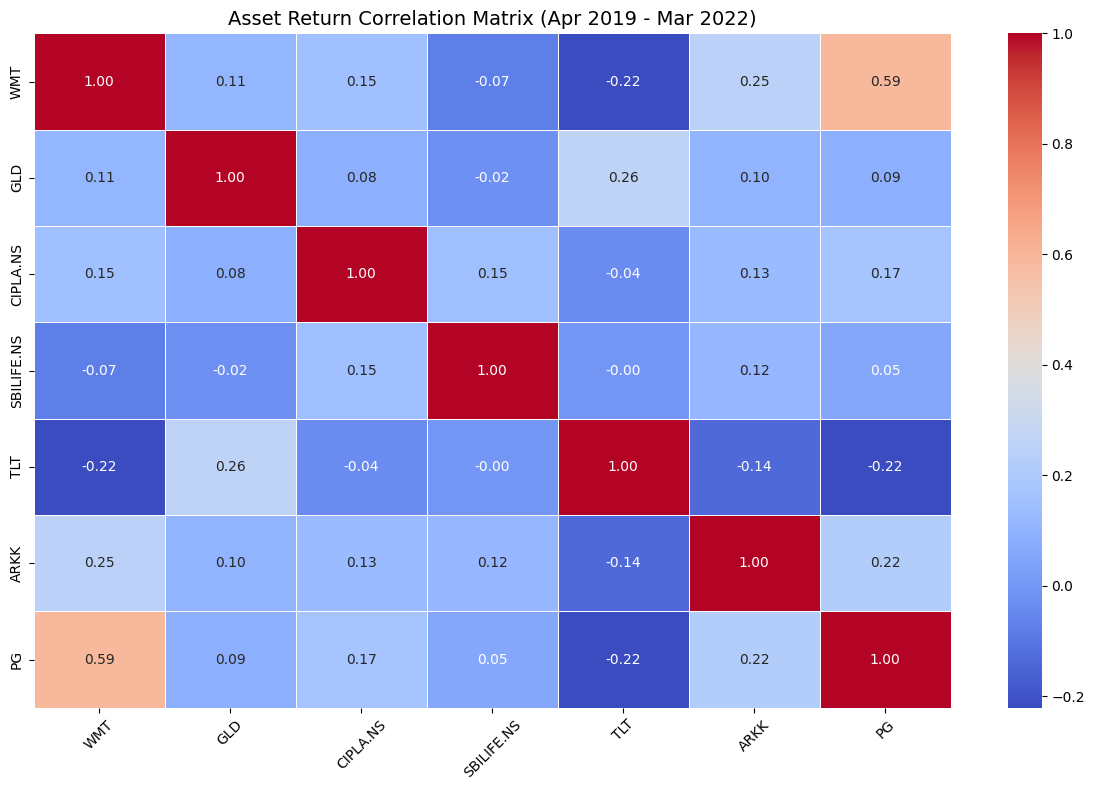

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(return_history.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Asset Return Correlation Matrix (Apr 2019 - Mar 2022)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##  5. Markowitz Optimizer

In [6]:
def markowitz_optimizer(mean_returns, cov_matrix, target_returns, weight_bounds=(0, 0.33), risk_free_rate=0.06):
    """Run Markowitz optimization to minimize risk for various target returns."""
    n_assets = len(mean_returns)
    weights = cp.Variable(n_assets)
    portfolio_risk = cp.quad_form(weights, cov_matrix)
    portfolio_return = mean_returns.values @ weights

    results = {'risks': [], 'weights': [], 'sharpe_ratios': []}

    for target in target_returns:
        constraints = [
            cp.sum(weights) == 1,
            weights >= weight_bounds[0],
            weights <= weight_bounds[1],
            portfolio_return >= target
        ]
        prob = cp.Problem(cp.Minimize(portfolio_risk), constraints)
        prob.solve()

        if weights.value is not None:
            w = weights.value
            vol = np.sqrt(w.T @ cov_matrix.values @ w)
            ann_return = mean_returns.values @ w * 252
            sharpe = (ann_return - risk_free_rate) / vol
            results['risks'].append(vol)
            results['weights'].append(w)
            results['sharpe_ratios'].append(sharpe)

    idx_best = int(np.argmax(results['sharpe_ratios']))
    return results, idx_best

##  6. Optimization

In [7]:
mean_returns = return_history.mean()
covariance_matrix = return_history.cov()
target_range = np.linspace(mean_returns.min(), mean_returns.max(), 50)

optimizer_output, best_portfolio_index = markowitz_optimizer(mean_returns, covariance_matrix, target_range)
opt_weights = optimizer_output['weights'][best_portfolio_index]

# Display optimal weights
print(" Final Portfolio Weights:")
for t, w in zip(tickers, np.round(opt_weights, 4)):
    print(f"{t}: {w:.4f}")

 Final Portfolio Weights:
WMT: 0.1821
GLD: 0.3254
CIPLA.NS: 0.1829
SBILIFE.NS: 0.2114
TLT: -0.0000
ARKK: 0.0223
PG: 0.0759


##  7. Backtest Optimized Portfolio

In [8]:
def backtest_portfolio(returns_df, weights, initial_capital=100000, annual_risk_free_rate=0.06):
    """Evaluate portfolio performance over time."""
    daily_returns = returns_df @ weights
    value_series = (1 + daily_returns).cumprod() * initial_capital

    total_return = value_series.iloc[-1] / initial_capital - 1
    ann_return = (1 + total_return) ** (1/3) - 1  # 3-year period
    ann_volatility = daily_returns.std() * np.sqrt(252)
    sharpe = (ann_return - annual_risk_free_rate) / ann_volatility

    metrics = {
        "Total Return": total_return,
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_volatility,
        "Sharpe Ratio": sharpe
    }

    return value_series, metrics

In [9]:
# Backtest on test data
test_prices, test_returns = fetch_data(tickers, test_start, test_end)
portfolio_value, performance_metrics = backtest_portfolio(test_returns, opt_weights)

# Display performance
print("\n Test Period Performance:")
for k, v in performance_metrics.items():
    print(f"{k}: {v:.4f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Test Period Performance:
Total Return: 0.5616
Annualized Return: 0.1602
Annualized Volatility: 0.1014
Sharpe Ratio: 0.9874



C:\Users\Bhavya Bharti\AppData\Local\Temp\ipykernel_28416\4137567209.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = all_data.pct_change().dropna()


##  8. Visualizations

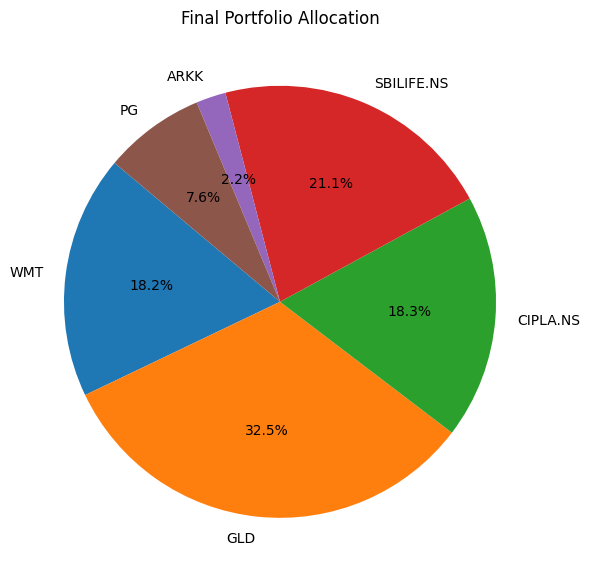

In [10]:
# 1. Pie Chart of Final Weights
plt.figure(figsize=(6, 6))
filtered_labels = [t for t, w in zip(tickers, opt_weights) if w > 0.01]
filtered_sizes = [w for w in opt_weights if w > 0.01]
plt.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140)
plt.title("Final Portfolio Allocation")
plt.axis('equal')
plt.tight_layout()
plt.show()

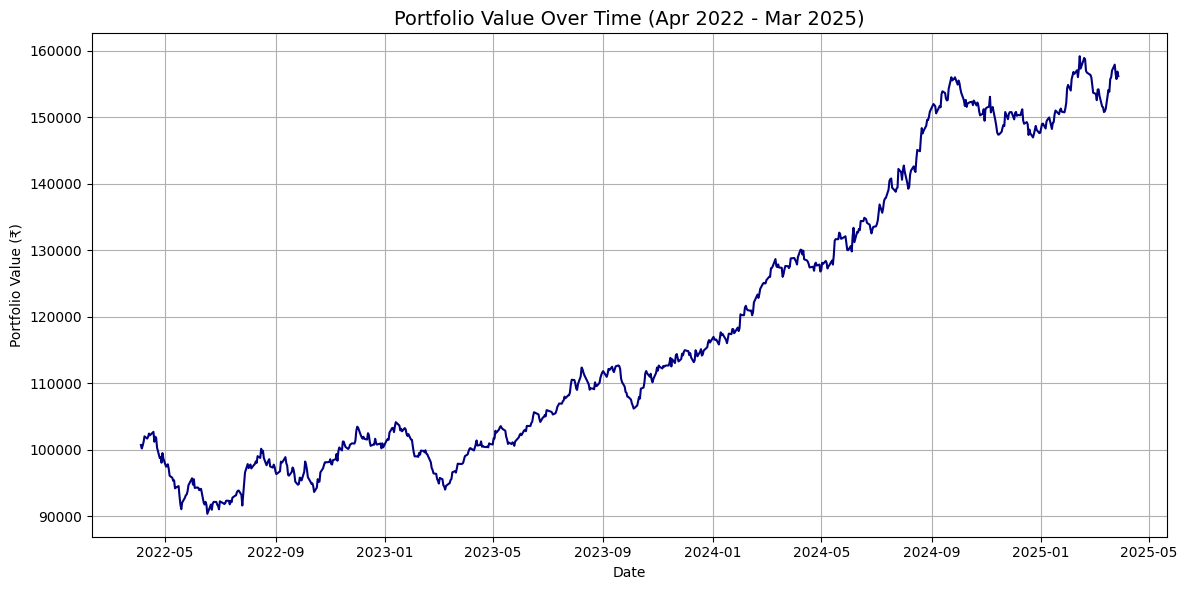

In [11]:
# 2. Portfolio Value Over Time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value.index, portfolio_value.values, label='Portfolio Value', color='navy')
plt.title("Portfolio Value Over Time (Apr 2022 - Mar 2025)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Portfolio Value (₹)")
plt.grid(True)
plt.tight_layout()
plt.show()

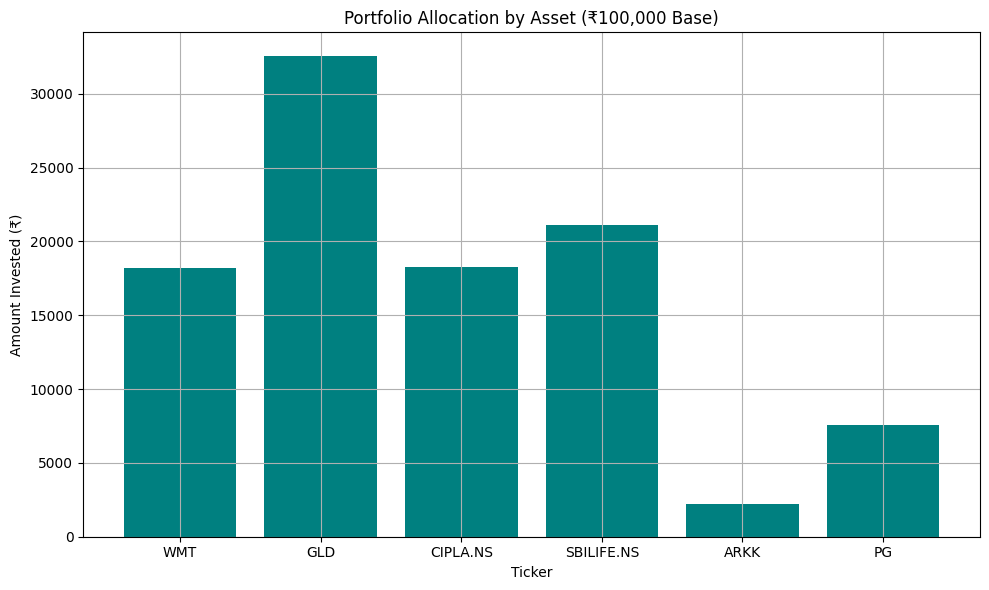

In [12]:
# 3. Bar Chart of Allocation in INR
plt.figure(figsize=(10, 6))
inr_allocation = np.array(opt_weights) * 100000
tickers_inr = [t for t, val in zip(tickers, inr_allocation) if val > 100]
values_inr = [val for val in inr_allocation if val > 100]

plt.bar(tickers_inr, values_inr, color='teal')
plt.title("Portfolio Allocation by Asset (₹100,000 Base)")
plt.xlabel("Ticker")
plt.ylabel("Amount Invested (₹)")
plt.grid(True)
plt.tight_layout()
plt.show()